In [1]:
import os
import cv2
import glob
import h5py
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
from utils_gen import gen_density_map_gaussian
import matplotlib.pyplot as plt
%matplotlib inline


root = 'data/ShanghaiTech/'
part_A_train = os.path.join(root, 'part_A/train_data', 'images')
part_A_test = os.path.join(root, 'part_A/test_data', 'images')
part_B_train = os.path.join(root, 'part_B/train_data', 'images')
part_B_test = os.path.join(root, 'part_B/test_data', 'images')
path_sets_A = [part_A_train, part_A_test]
path_sets_B = [part_B_train, part_B_test]
img_paths_A = []
for path in path_sets_A:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_A.append(img_path)
print(len(img_paths_A))
img_paths_B = []
for path in path_sets_B:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_B.append(img_path)
print(len(img_paths_B))

Using TensorFlow backend.


482
716


In [2]:
for dataset in ['A', 'B']:
    img_paths = eval('img_paths_'+dataset)
    for img_path in tqdm(img_paths):
        img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
        img = cv2.imread(img_path)
        sigma = 4  if 'part_A' in img_path else 15
        k = np.zeros((img.shape[0], img.shape[1]))
        gt = pts["image_info"][0, 0][0, 0][0]
        for i in range(len(gt)):
            if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
                k[int(gt[i][1]), int(gt[i][0])] = 1

        DM = gen_density_map_gaussian(k, gt, sigma=sigma)

        file_path = img_path.replace('.jpg', '.h5').replace('images', 'ground')
        with h5py.File(file_path, 'w') as hf:
            hf['density'] = DM

100%|██████████| 716/716 [01:01<00:00, 11.55it/s]


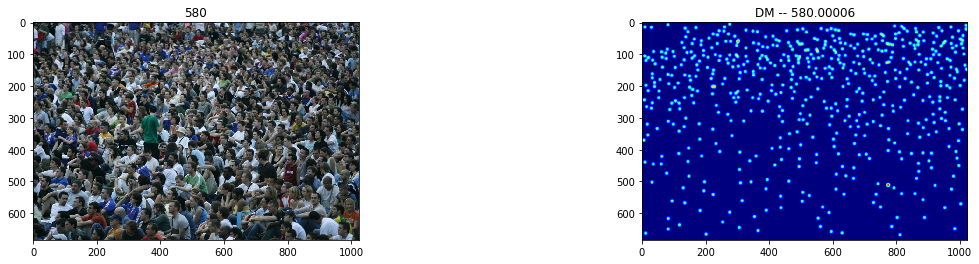

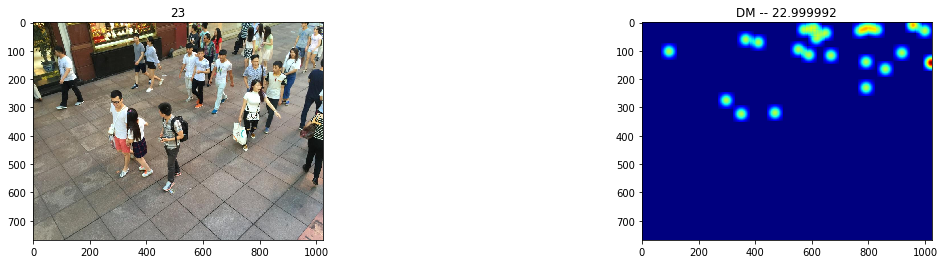

In [4]:
# Show a sample
img_paths = ['data/ShanghaiTech/part_A/train_data/images/IMG_196.jpg',
             'data/ShanghaiTech/part_B/test_data/images/IMG_1.jpg']
for img_path in img_paths:
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)
    
    sigma = 4  if 'part_A' in img_path else 15
    k = np.zeros((img.shape[0], img.shape[1]))
    gt = pts["image_info"][0, 0][0, 0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    DM = gen_density_map_gaussian(k, gt, sigma=sigma)
    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img_ori)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(np.squeeze(DM), cmap=plt.cm.jet)
    ax1.set_title('DM -- '+str(np.sum(DM)))
    plt.show()